# Adatok betöltése és vizualizációja
## **Módszer:** kaggle verseny letöltése a /content mappába, majd kicsomagolás
## **Fontos:** (kb 60GB szükséges átmenetileg) zip mappa törlése a kicsomagolás után, hogy visszakapjunk 30GB-ot!

Authentikáció - itt fel kell tölteni a kaggle.json file-t

In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"horvthbotondtrylvw","key":"809fb1d01438b6e4dc65d2324c14c1f7"}'}

A hitelesítési adatok feltöltése, alkalmazása

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Letöltés a /content mappába

In [3]:
!kaggle competitions download -c airbus-ship-detection -p /content

100% 28.6G/28.6G [24:02<00:00, 21.9MB/s]
100% 28.6G/28.6G [24:02<00:00, 21.3MB/s]


Kicsomagolás zip formátumból (a zip mappa törlését azután csináltam kézzel, hogy ez befejeződött)

In [4]:
!unzip /content/airbus-ship-detection.zip -d /content/airbus-ship-detection


A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: /content/airbus-ship-detection/train_v2/f9775b70e.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f977a470c.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9780bfaf.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9782bdfe.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9785ca49.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9785e462.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97a719d5.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97afa376.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97b85e3e.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bd0b11.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bd6b80.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bfb1b2.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97c8cbbe.jpg  
  inflating: /content/airbus-ship-detection/train_v2

Ellenőrzés, hogy megvannak-e a szükséges elemek

In [5]:
!ls /content/airbus-ship-detection

sample_submission_v2.csv  test_v2  train_ship_segmentations_v2.csv  train_v2


Mintahasználat - 3-3 kép kirajzolása a képekből

Displaying first 3 images from the train_v2 folder:


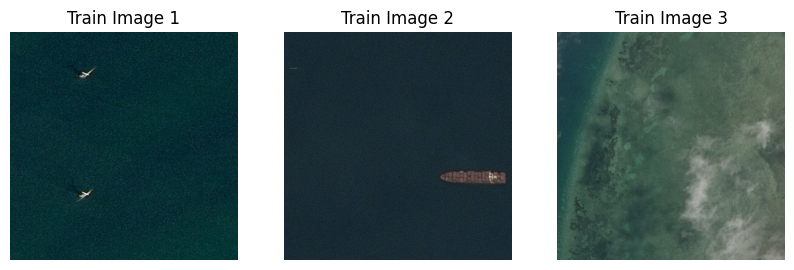

Displaying first 3 images from the test_v2 folder:


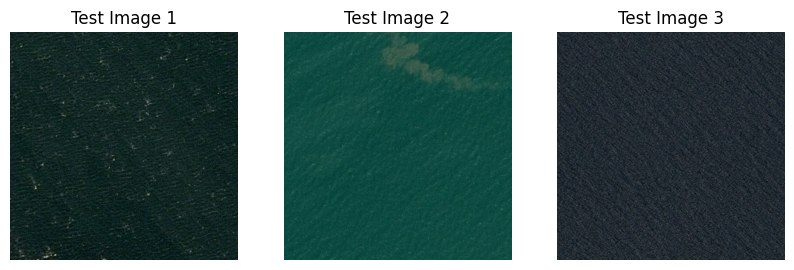

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# path of the train and test folders
train_folder = '/content/airbus-ship-detection/train_v2/'
test_folder = '/content/airbus-ship-detection/test_v2/'

# Get the first 3 image filenames from both train and test directories
train_images = os.listdir(train_folder)[:3]
test_images = os.listdir(test_folder)[:3]

# Function to display images
def show_images(image_folder, image_list, title):
    plt.figure(figsize=(10,5))
    for idx, image_file in enumerate(image_list):
        img_path = os.path.join(image_folder, image_file)
        img = Image.open(img_path)
        plt.subplot(1, 3, idx+1)
        plt.imshow(img)
        plt.title(f'{title} {idx+1}')
        plt.axis('off')  # Turn off axis labels for a cleaner look
    plt.show()

# Show first 3 train images
print("Displaying first 3 images from the train_v2 folder:")
show_images(train_folder, train_images, 'Train Image')

# Show first 3 test images
print("Displaying first 3 images from the test_v2 folder:")
show_images(test_folder, test_images, 'Test Image')


Adatok letöltése, előkészítése

In [ ]:
"""
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from skimage import io


random_seed = 42
np.random.seed(random_seed)


dataset = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')


train_split = 0.8
valid_split = 0.1
test_split = 0.1

#esetleg shuffle

#X_train = [;]
X_test =
X_valid =

Y_train =
Y_test =
Y_valid =

class ShipDataset(Dataset):


    def __init__(self, dataframe, image_dir, transform=None):

        self.ships_frame = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.ships_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.ships_frame.iloc[idx, 0])
        image = io.imread(img_name)
        ships = self.ships_frame.iloc[idx, 1:]
        ships = convert_to_2d_tensor(ships)
        sample = {'image': image, 'ships': ships}


        return sample

def convert_to_2d_tensor(data):
    # Step 1: Split the string into individual numbers and convert to integers
    numbers = list(map(int, data.split()))

    # Step 2: Reshape the list into pairs (start, length)
    arr = np.array(numbers).reshape(-1, 2)  # Each pair is (start position, length)

    # Step 3: Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(arr, dtype=torch.int32)

    return tensor
"""